In [2]:
# Copyright 2018, JinYoung Kim Softcomputing LAB all rights reserved.
%matplotlib inline
from keras.models import *
from keras.layers import *
from keras.datasets import *
from keras.utils import *
from keras.callbacks import *
from keras import backend as K

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm *= 1000
        cm = np.round(cm)
        cm /= 1000
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Load data

## Download MNIST dataset

In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## Visualization

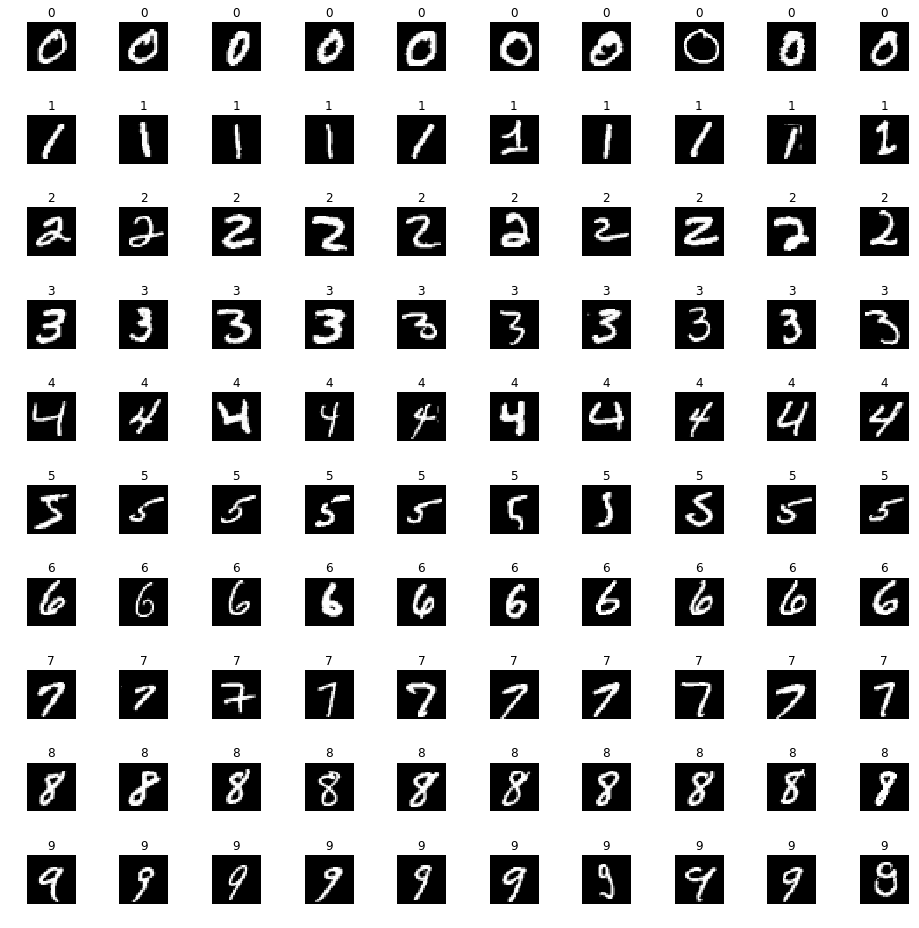

In [5]:
plt.figure(figsize=(13,13))
for i in range(np_utils.to_categorical(Y_train).shape[1]):
    for j in range(10):
        plt.subplot(10, np_utils.to_categorical(Y_train).shape[1], i * 10 + j + 1)
        plt.imshow(X_train[Y_train==i][j], cmap='gray')
        plt.axis('off')
        plt.title(str(i))
plt.tight_layout()
plt.show()

## Pre-processing data

In [6]:
X_train, X_test = X_train / (2. / 255.) - 1, X_test / (2. / 255.) - 1
X_train = np.reshape(X_train, [-1, X_train.shape[1] * X_train.shape[2]])
X_test = np.reshape(X_test, [-1, X_test.shape[1] * X_test.shape[2]])
Y_train, Y_test = np_utils.to_categorical(Y_train), np_utils.to_categorical(Y_test)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


# Build Basic NN

In [7]:
def Basic_NN(hidden_units, n_class, activation='tanh', dropout = False, dropout_rate = -1, batchnormalization = False):
    if dropout and dropout_rate < 0:
        print('If you use dropout, specify dropout rate between 0 and 1')
        return -1
    def _f(inp):
        x = inp
        for i in range(len(hidden_units)):
            x = Dense(hidden_units[i], activation = activation)(x)
            if batchnormalization:
                x = BatchNormalization()(x)
            if dropout:
                x = Dropout(dropout_rate)(x)
        out = Dense(n_class, activation='softmax')(x)
        return out
    return _f

## Params

In [8]:
# The number of hidden layers = len(hidden_units)
# The number of nodes in i-th hidden layers = hidden_units[i-1]
hidden_units = [512, 512, 512]

# The number of classes
n_class = Y_train.shape[1]

# Activation functions: 'tanh' (default), 'linear', 'relu', 'elu', 'selu', 'sigmoid', etc.
activation = 'tanh'

# Several layers
dropout = True
dropout_rate = 0.25
batchnormalization = True

# Optimizers: 'sgd', 'rmsprop', 'adadelta', 'adam'
optimizer = 'adam'

# Params for training
epochs = 100
batch_size = 512

# Callbacks
callbacks = [EarlyStopping(patience = 5, verbose = 1),
            ReduceLROnPlateau(patience = 3, verbose = 1)]

## Construct model

In [9]:
inp = Input(X_train.shape[1:])
out = Basic_NN(hidden_units, n_class, activation, dropout, dropout_rate, batchnormalization)(inp)

model = Model(inp, out)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

## Train

In [10]:
history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, verbose = 2,
                   validation_data = [X_test, Y_test], callbacks = callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 5s - loss: 0.6387 - acc: 0.8095 - val_loss: 0.4122 - val_acc: 0.8814
Epoch 2/100
 - 1s - loss: 0.4653 - acc: 0.8544 - val_loss: 0.4882 - val_acc: 0.8525
Epoch 3/100
 - 1s - loss: 0.4252 - acc: 0.8638 - val_loss: 0.4001 - val_acc: 0.8730
Epoch 4/100
 - 1s - loss: 0.4015 - acc: 0.8686 - val_loss: 0.3560 - val_acc: 0.8897
Epoch 5/100
 - 1s - loss: 0.3840 - acc: 0.8740 - val_loss: 0.3578 - val_acc: 0.8815
Epoch 6/100
 - 1s - loss: 0.3849 - acc: 0.8738 - val_loss: 0.3202 - val_acc: 0.8987
Epoch 7/100
 - 1s - loss: 0.3887 - acc: 0.8725 - val_loss: 0.3110 - val_acc: 0.9036
Epoch 8/100
 - 1s - loss: 0.3949 - acc: 0.8716 - val_loss: 0.3746 - val_acc: 0.8766
Epoch 9/100
 - 1s - loss: 0.4042 - acc: 0.8669 - val_loss: 0.3429 - val_acc: 0.8901
Epoch 10/100
 - 1s - loss: 0.4172 - acc: 0.8615 - val_loss: 0.3287 - val_acc: 0.8958
Epoch 11/100

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
 - 1s - loss: 

In [11]:
training_result = model.evaluate(X_train, Y_train, verbose = 0)
print ('Training loss: %.4f, acc: %.2f%%'%(training_result[0], training_result[1] * 100))
test_result = model.evaluate(X_test, Y_test, verbose = 0)
print ('Training loss: %.4f, acc: %.2f%%'%(test_result[0], test_result[1] * 100))

Training loss: 0.1871, acc: 94.03%
Training loss: 0.2446, acc: 92.45%


## Visualization

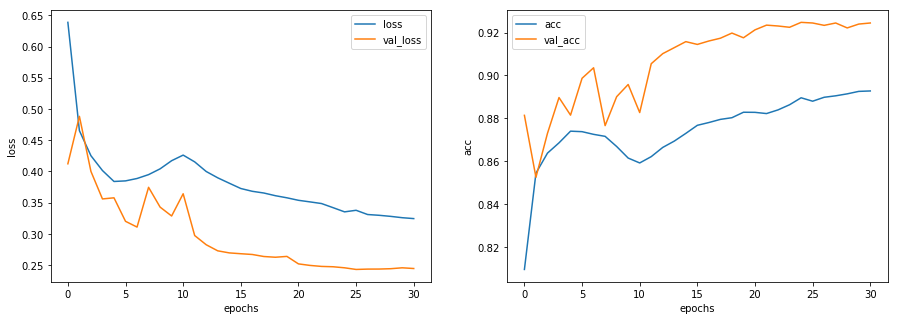

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(['acc', 'val_acc'])
plt.show()

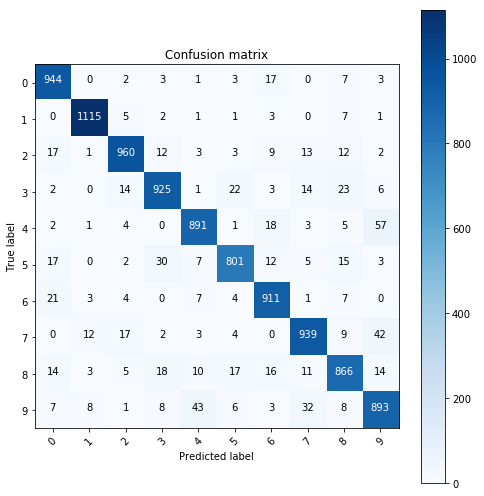

In [13]:
pred = np.argmax(model.predict(X_test, verbose = 0), axis=1)
cm = confusion_matrix(np.argmax(Y_test, axis=1), pred)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, classes = [str(i) for i in range(Y_train.shape[1])])
plt.tight_layout()
plt.show()

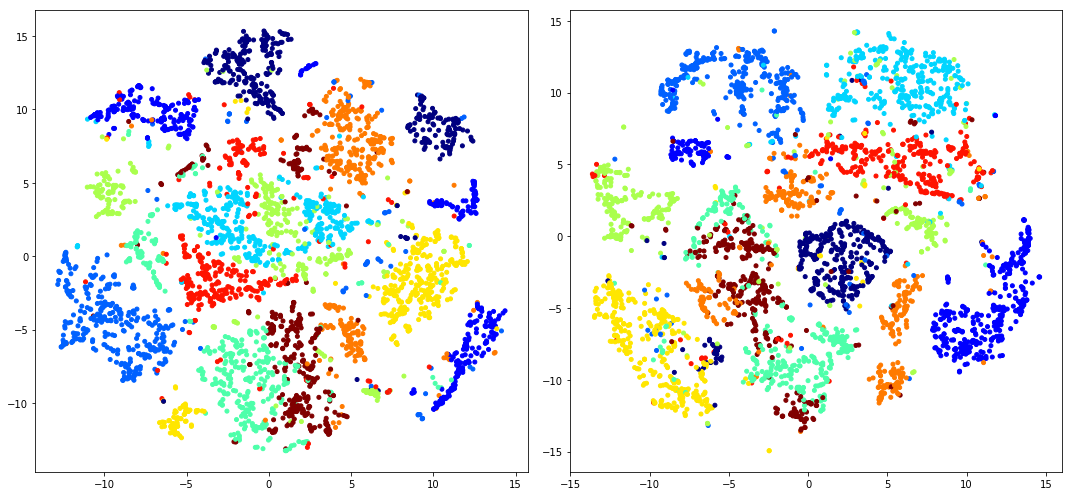

In [14]:
# Caution Below process takes long long time

# TSNE for original data
n_samples = 4000
rand_idx = np.random.randint(X_test.shape[0], size=[n_samples,])
tsne = TSNE()
tsne_output = tsne.fit_transform(X_test[rand_idx])

# TSNE for the second last layer's output
layer_func = K.function([model.layers[0].input, K.learning_phase()],[model.layers[-2].output])
layer_output = layer_func([X_test[rand_idx], 0])[0]
tsne = TSNE()
tsne_output2 = tsne.fit_transform(layer_output)

plt.figure(figsize=(15,7))

# plot original data
plt.subplot(1,2,1)
plt.scatter(tsne_output[:, 0], tsne_output[:,1], s = 4**2, c = np.argmax(Y_test, axis=1)[rand_idx], cmap='jet')

# plot the second last layer's output
plt.subplot(1,2,2)
plt.scatter(tsne_output2[:, 0], tsne_output2[:,1], s = 4**2, c = np.argmax(Y_test, axis=1)[rand_idx], cmap='jet')
plt.tight_layout()

plt.show()